<a href="https://colab.research.google.com/github/AnabelBerumen/DataScientist/blob/main/modelos/KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sistemas de recomendaciòn

cargando datos de[ movie lens](http://files.grouplens.org/datasets/movielens/)

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('/content/u.data.csv', sep='\t', header=None)

In [ ]:
type(df)

pandas.core.frame.DataFrame

In [ ]:
df.head(3)

,0,1,2,3
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116


In [ ]:
df.shape

(100000, 4)

In [ ]:
df.columns = ['UserID', 'ItemID', "Rating", 'TimeStamp']
df.head(4)

,UserID,ItemID,Rating,TimeStamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923


Anàlisis exploratorio de ítems

(array([ 6110.,     0., 11370.,     0.,     0., 27145.,     0., 34174.,
            0., 21201.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

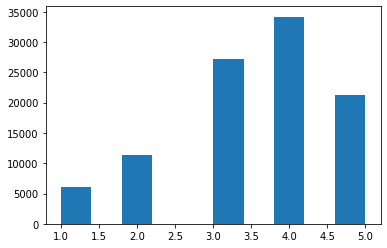

In [ ]:
import matplotlib.pyplot as plt

plt.hist(df.Rating)

(array([11459.,  5724., 19359.,  9315.,  9396., 10083.,  6175.,  9603.,
        10048.,  8838.]),
 array([8.74724710e+08, 8.76580903e+08, 8.78437096e+08, 8.80293288e+08,
        8.82149481e+08, 8.84005674e+08, 8.85861867e+08, 8.87718060e+08,
        8.89574252e+08, 8.91430445e+08, 8.93286638e+08]),
 <a list of 10 Patch objects>)

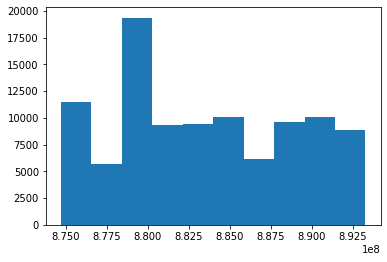

In [ ]:
plt.hist(df.TimeStamp)

In [ ]:
df.groupby(['Rating'])['UserID'].count()

Rating
1     6110
2    11370
3    27145
4    34174
5    21201
Name: UserID, dtype: int64

(array([1.146e+03, 2.490e+02, 1.390e+02, 6.700e+01, 3.800e+01, 2.400e+01,
        7.000e+00, 5.000e+00, 6.000e+00, 1.000e+00]),
 array([  1. ,  59.2, 117.4, 175.6, 233.8, 292. , 350.2, 408.4, 466.6,
        524.8, 583. ]),
 <a list of 10 Patch objects>)

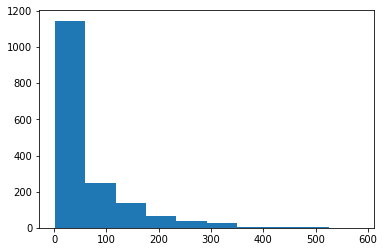

In [ ]:
plt.hist(df.groupby(['ItemID'])['ItemID'].count())

Representación en forma matricial

In [ ]:
n_users = df.UserID.unique().shape[0]
n_users

943

In [ ]:
n_items = df.ItemID.unique().shape[0]
n_items

1682

In [ ]:
ratings = np.zeros((n_users, n_items))

In [ ]:
for row in df.itertuples():
  ratings[row[1]-1, row[2]-1] = row[3]

In [ ]:
type(ratings)

numpy.ndarray

In [ ]:
ratings.shape

(943, 1682)

In [ ]:
ratings

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

In [ ]:
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0]*ratings.shape[1])
sparsity *= 100
print('Coeficiente de sparseidad: {:4.2f}%'.format(sparsity))


Coeficiente de sparseidad: 6.30%


### Crear conjutos de entrenamiento y validación

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
ratings_train, ratings_test = train_test_split(ratings, test_size = 0.3, random_state=42)

In [ ]:
ratings_train.shape

(660, 1682)

## Filtro Colaborativo basado en usuarios
* Matriz de similaridad entre los usuarios
* Predecir la valoración desconocida de un ítem *i* para un usuario activo *u* basandonos en la suma ponderada de todas las valoraciones del resto de usuarios para dicho ítem
* Recomendaremos los nuevos ítems a los usuarios según lo estableciso en los pasos anteriores

In [ ]:
import numpy as np
import sklearn

In [ ]:
# matriz de similaridad
sim_matrix = 1 - sklearn.metrics.pairwise.cosine_distances(ratings_train)

In [ ]:
type(sim_matrix)

numpy.ndarray

In [ ]:
sim_matrix.shape

(660, 660)

In [ ]:
users_predictions = sim_matrix.dot(ratings_train) / np.array([np.abs(sim_matrix).sum(axis=1)]).T
users_predictions

array([[2.10259747e+00, 5.86975978e-01, 3.40264192e-01, ...,
        0.00000000e+00, 7.33611460e-03, 6.04379414e-03],
       [1.40999723e+00, 2.91863934e-01, 2.68085289e-01, ...,
        0.00000000e+00, 3.50378592e-03, 2.32963985e-03],
       [1.69014833e+00, 3.13648440e-01, 3.26127887e-01, ...,
        0.00000000e+00, 3.25391767e-03, 1.77210119e-03],
       ...,
       [1.73393747e+00, 4.06719333e-01, 3.21166908e-01, ...,
        0.00000000e+00, 2.71269625e-03, 9.00511411e-03],
       [2.34361031e+00, 8.10544770e-01, 4.73941025e-01, ...,
        0.00000000e+00, 1.01130066e-02, 9.66427605e-03],
       [2.36796969e+00, 5.98146138e-01, 3.85569804e-01, ...,
        0.00000000e+00, 6.39996638e-03, 5.37442746e-03]])

In [ ]:
from sklearn.metrics import mean_squared_error

def get_mse(preds, actuals):
  if preds.shape[0] == actuals.shape[1]:
    actuals = actuals.T
    
  # Flatten copia disminuyendo a una dimensión
  preds = preds[actuals.nonzero()].flatten()
  actuals = actuals[actuals.nonzero()].flatten()
  return mean_squared_error(preds, actuals)

In [ ]:
get_mse(users_predictions, ratings_train)

7.878218313143215

In [ ]:
get_mse(users_predictions, ratings_test)

8.745164067978985

Filtro colaborativo basado en los KNN

In [ ]:
from sklearn.neighbors import NearestNeighbors
import sklearn.metrics.pairwise as smp

k = 3

neighbors = NearestNeighbors(n_neighbors = k, radius='cosine', n_jobs=1)
neighbors.fit(ratings_train)

NearestNeighbors(n_jobs=1, n_neighbors=3, radius='cosine')

In [ ]:
top_k_distances, top_k_users = neighbors.kneighbors(ratings_train, return_distance=True)
top_k_distances.shape

(660, 3)

In [ ]:
top_k_distances[0]

array([ 0.        , 41.71330723, 43.3474336 ])

In [ ]:
top_k_users[0]

array([  0, 211,  16])

In [ ]:
users_predicts_k = np.zeros(ratings_train.shape)

for i in range(ratings_train.shape[0]): # para cada usuario del conjunto de entrenamiento
  users_predicts_k[i,:] = top_k_distances[i].T.dot(ratings_train[top_k_users][i])/np.array([np.abs(top_k_distances[i].T).sum(axis=0)]).T


In [ ]:
users_predicts_k.shape

(660, 1682)

In [ ]:
users_predicts_k

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.49462669, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [4.03816173, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
get_mse(users_predicts_k, ratings_train)

8.394685749753174

## Filtro colaborativo basado en items

In [ ]:
n_movies = ratings_train.shape[1]
n_movies

1682

In [ ]:
neighbors = NearestNeighbors(n_neighbors = n_movies, radius='cosine', n_jobs=1)
neighbors.fit(ratings_train.T)

NearestNeighbors(n_jobs=1, n_neighbors=1682, radius='cosine')

In [ ]:
top_k_distances, top_k_items = neighbors.kneighbors(ratings_train.T, return_distance=True)

print(top_k_distances.shape)
print(top_k_items.shape)

(1682, 1682)
(1682, 1682)


In [ ]:
top_k_items

array([[   0,  120,  404, ...,  285,  312,  301],
       [   1,  575,  232, ...,  257,   99,   49],
       [   2,  742, 1094, ...,  180,   99,   49],
       ...,
       [1565, 1571, 1570, ...,  180,   99,   49],
       [1680, 1671, 1582, ...,  180,   99,   49],
       [1681, 1596, 1592, ...,  180,   99,   49]])

In [ ]:
items_preds = ratings_train.dot(top_k_distances) / np.array([np.abs(top_k_distances).sum(axis=1)])
items_preds.shape

(660, 1682)

In [ ]:
items_preds

array([[0.        , 0.31842643, 0.37009323, ..., 1.44850442, 1.4566397 ,
        1.54530823],
       [0.        , 0.0545379 , 0.06227954, ..., 0.20078701, 0.20112087,
        0.21332472],
       [0.        , 0.03522479, 0.04073126, ..., 0.18456903, 0.18654661,
        0.20076303],
       ...,
       [0.        , 0.08968346, 0.10313623, ..., 0.42050197, 0.4196067 ,
        0.45863507],
       [0.        , 0.25835756, 0.29918119, ..., 1.31043371, 1.32278067,
        1.41390683],
       [0.        , 0.07174777, 0.08538024, ..., 0.25535196, 0.25259645,
        0.26199652]])

In [ ]:
get_mse(items_preds, ratings_train)

11.172565375125632

In [ ]:
get_mse(items_preds, ratings_test)

11.876775601508902

In [ ]:
name_movie = pd.read_csv('/content/u.item', sep='|', encoding='latin-1')

name_movie.head()

,1,Toy Story (1995),01-Jan-1995,Unnamed: 3,http://us.imdb.com/M/title-exact?Toy%20Story%20(1995),0,0.1,0.2,1.1,1.2,...,0.6,0.7,0.8,0.9,0.10,0.11,0.12,0.13,0.14,0.15
0,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,6,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,01-Jan-1995,NaN,http://us.imdb.com/Title?Yao+a+yao+yao+dao+wai...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#  0,  120,  404, ...,  285,  312,  301]
name_movie.iloc[[0,119,403],:]

,1,Toy Story (1995),01-Jan-1995,Unnamed: 3,http://us.imdb.com/M/title-exact?Toy%20Story%20(1995),0,0.1,0.2,1.1,1.2,...,0.6,0.7,0.8,0.9,0.10,0.11,0.12,0.13,0.14,0.15
0,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
119,121,Independence Day (ID4) (1996),03-Jul-1996,NaN,http://us.imdb.com/M/title-exact?Independence%...,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
403,405,Mission: Impossible (1996),22-May-1996,NaN,http://us.imdb.com/M/title-exact?Mission:%20Im...,0,1,1,0,0,...,0,0,0,0,1,0,0,0,0,0


### Filtrado colaborativo basado en KNN

In [ ]:
k = 30
neighbors = NearestNeighbors(n_neighbors=k, n_jobs=1, radius='cosine')
neighbors.fit(ratings_train.T) #Traspuesto xq items estan en columnas

top_k_distances, top_k_items = neighbors.kneighbors(ratings_train.T, return_distance=True)

In [ ]:
top_k_distances.shape

(1682, 30)

In [ ]:
top_k_distances[0]

array([ 0.        , 53.12249994, 54.38749856, 55.50675635, 56.49778757,
       56.9473441 , 57.21013896, 57.81003373, 58.10335619, 58.16356248,
       58.19793811, 58.37807808, 58.70264049, 58.83876273, 58.97457079,
       59.52310476, 59.61543424, 59.84981203, 59.89156869, 59.94163828,
       60.15812497, 60.35726965, 60.37383539, 60.63002556, 60.86049622,
       61.11464636, 61.31883887, 61.37589103, 61.57109712, 61.80614856])

In [ ]:
preds = np.zeros(ratings_train.T.shape)

for i in range(ratings_train.shape[0]):
  preds[i,:] = top_k_distances[i].dot(ratings_train.T[top_k_items][i]) / np.array([np.abs(top_k_distances[i]).sum(axis=0)]).T

In [ ]:
get_mse(preds, ratings_train)

9.209202717639572

In [ ]:
get_mse(preds, ratings_test)

11.637497220153886

In [ ]:
import chart_studio.plotly as py

import plotly.graph_objects as go

from sklearn.preprocessing import StandardScaler



# Necesario para exportar los gráficos, y hace falta registrarse:

import chart_studio

chart_studio.tools.set_credentials_file(username="", api_key="")



# Normalizamos los datos para centrarlos en 0

X_std = StandardScaler().fit_transform(X)



# Representamos los histogramas

traces = []

data = []



legend = {0:True, 1:True, 2:True, 3:True}



colors = {'setosa': 'rgb(255,127,20)',

         'versicolor': 'rgb(31, 220, 120)',

         'virginica': 'rgb(44, 50, 180)'

         }



for col in range(4):

    for key in colors:

        traces.append(go.Histogram(x=X_std[Y==key, col], opacity = 0.7,

                                   xaxis="x%s"%(col+1), marker=go.histogram.Marker(color=colors[key]),

                                   name = key, showlegend=legend[col]))



    legend = {0:False, 1:False, 2:False, 3:False}



for x in range(len(traces)):

    data.append(go.Histogram(traces[x]))

layout = go.Layout(barmode="overlay",

                xaxis=go.layout.XAxis(domain=[0,0.25], title="Long. Sépalos (cm)"),

                xaxis2=go.layout.XAxis(domain=[0.3, 0.5], title = "Anch. Sépalos (cm)"),

                xaxis3=go.layout.XAxis(domain = [0.55, 0.75], title = "Long. Pétalos (cm)"),

                xaxis4=go.layout.XAxis(domain=[0.8,1.0], title = "Anch. Pétalos (cm)"),

                yaxis=go.layout.YAxis(title="Número de ejemplares"),

                title="Distribución de los rasgos de las diferentes flores Iris")



fig = go.Figure(data = data, layout = layout)

fig.show()